## This notebook is intended to analyze an optimal amount of clusters to pass later to Petrel clustering based on 17 maps of various geological, geochemical and geomechnical attributes. Additionaly, Kohonen self-organized map was tested but failed because of too many input points

In [2]:
#БАЗОВЫЕ БИБЛИОТЕКИ
import pandas as pd
import numpy as np
import glob
import os

#CИСТЕМНЫЕ БИБЛИОТЕКИ
import sys
import glob

#ГРАФИЧЕСКИЕ БИБЛИОТЕКИ
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#БИБЛИОТЕКА МАШИННОГО ОБУЧЕНИЯ
import sklearn

#БИБЛИОТЕКИ И МОДУЛИ СТАТИСТИЧЕСКИХ ВЫЧИСЛЕНИЙ
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, classification_report, accuracy_score
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

#БИБЛИОТЕКИ ДЛЯ СОЗДАНИЯ САМООРГАНИЗУЮЩИХСЯ КАРТ КОХОНЕНА
from minisom import MiniSom   


#БИБЛИОТЕКИ И МОДУЛИ ВЫБОРА МОДЕЛЕЙ
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV


# БИБЛИОТЕКИ И МОДУЛИ ЛИНЕЙНЫХ МОДЕЛЕЙ
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

## 1. СБОР КАРТ ОТДЕЛЬНЫХ ПАРАМЕТРОВ В ЕДИНЫЙ DATAFRAME

In [21]:
features = ['X', 'Y']
os.chdir(r'C:\Users\user\Documents\Palyan Production\Points for clustering')

counter = 0
for i in os.listdir(r'C:\Users\user\Documents\Palyan Production\Points for clustering'):
    counter += 1
    features.append(i)
    txt = pd.read_csv(i, sep = ' ', names = ['X', 'Y', i])
    if counter ==1:
        data = txt
    else:
        data[i] = txt[i]
        
    print('File processed {a}'. format(a = counter))



File processed 1
File processed 2
File processed 3
File processed 4
File processed 5
File processed 6
File processed 7
File processed 8
File processed 9
File processed 10
File processed 11
File processed 12
File processed 13
File processed 14
File processed 15
File processed 16
File processed 17
File processed 18


In [22]:
data.dropna(subset = ['Class'], inplace = True)
data['Class'].astype('int64')
data.head()

,X,Y,Anisotropy,Bo,BR,Class,HIo,Net_Pay,PERM,PHID,PHIT,Poisson,Ro,Rs,Structure,Thickness,TOCo,TSTR,Viscosity,Young
0,392290.066803,6.843612e+06,1.140213,1.352365,0.360885,1.0,391.818207,14.894969,2.409361,0.060384,0.119428,0.265828,0.715255,202.656723,2205.101318,25.590252,5.482913,5.085021,0.362372,9.351511
1,392340.174105,6.843612e+06,1.139357,1.353420,0.354758,1.0,393.406677,15.080671,2.448919,0.060583,0.119103,0.265692,0.715813,203.258469,2208.336426,25.595066,5.503797,5.070307,0.362173,9.397871
2,392390.281407,6.843612e+06,1.140035,1.354870,0.350582,1.0,395.369110,15.071511,2.549307,0.060737,0.118759,0.265567,0.716222,204.007599,2211.048340,25.584805,5.529271,5.062988,0.362054,9.450643
3,392440.388709,6.843612e+06,1.141152,1.348404,0.367075,1.0,388.217834,14.037920,2.396553,0.060099,0.119243,0.265493,0.715181,200.549255,2204.227539,25.534119,5.416934,5.061965,0.362316,9.506416
4,392490.496011,6.843612e+06,1.141048,1.350887,0.360110,1.0,390.676941,14.515652,2.398664,0.060022,0.118898,0.265363,0.715721,202.007919,2208.205566,25.505535,5.465887,5.063825,0.362144,9.573301


## 2. РАСЧЕТ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ С ИСПОЛЬЗОВАНИЕМ К-СРЕДНИХ

In [172]:
X = data[features[2:]]

distortions = []
K = range(1,20)

for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    distortions.append(kmeans.inertia_)
    

## 3. РАСЧЕТ ГРАФИКА ДЛЯ ОПРЕДЕЛЕНИЯ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАССОВ

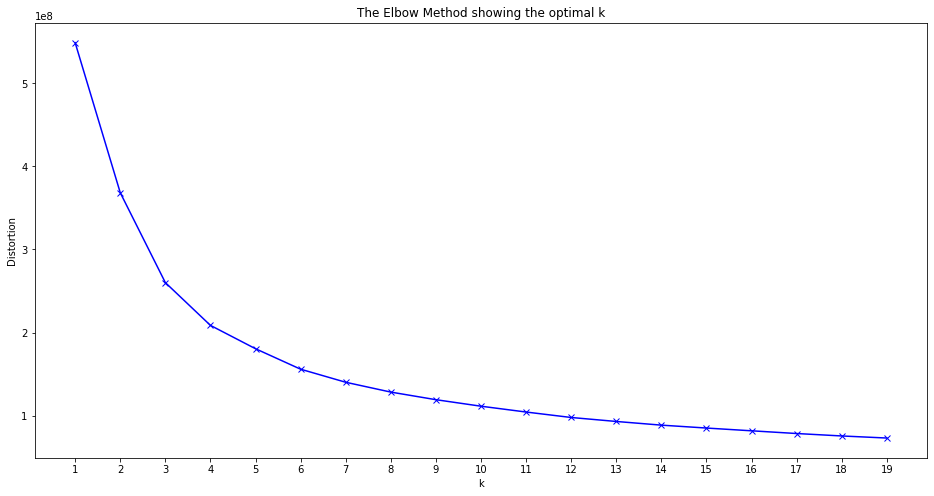

In [177]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(ticks = K)
plt.title('The Elbow Method showing the optimal k')
plt.show()

## 3. ПОДГОТОВКА ДАННЫХ И СОЗДАНИЕ SOM

In [173]:
sc = StandardScaler()
X_SOM = sc.fit_transform(X)

# Существует правило, которое определяет адекатное количество нейронов - 5 х корень из N, где N - число наблюдений. В нашем случае, N очень велико (около 120 000),
# что означает, что размер SOM должен быть 1200 на 1200 нейронов, что очень долго посчитать. Стохатически фильтровать выборку также нельзя, так как мы можем потерять
# простраственные закономенрности

som_shape = (50,50)
som = MiniSom(som_shape[0], som_shape[1], X_SOM.shape[1], sigma=0.5, learning_rate=0.5)
som.train_batch(X_SOM, 20, verbose=True)

 [ 20 / 20 ] 100% - 0:00:00 left 
 quantization error: 3.2884466731023814


In [174]:
# По результатам обочения, каждый нейрон получает вектор весов, длина котрого равна количеству переменых в обучающей выборке. например, если в нашей выборке только пористость и проницаемость,
# то у каждого нейрона есть вектор, длиной 2 единицы, в котором записаны веса для поритсости и проницаемости для этого нейрона после обучения. Можно считать эти точки координатами нейронов, тогда, 
# можно найти вектора (расстояния) между нейронаи. Таким образом получается матрица расстояний som.distance_map(), в которой для каждого нейрона прописано Евклидово расстояние до всех других нейронов. 
# Если размер SOM 10 x 10, то и размер матрицы расстояний будет такой же.

dist = som.distance_map()
dist.shape


(50, 50)

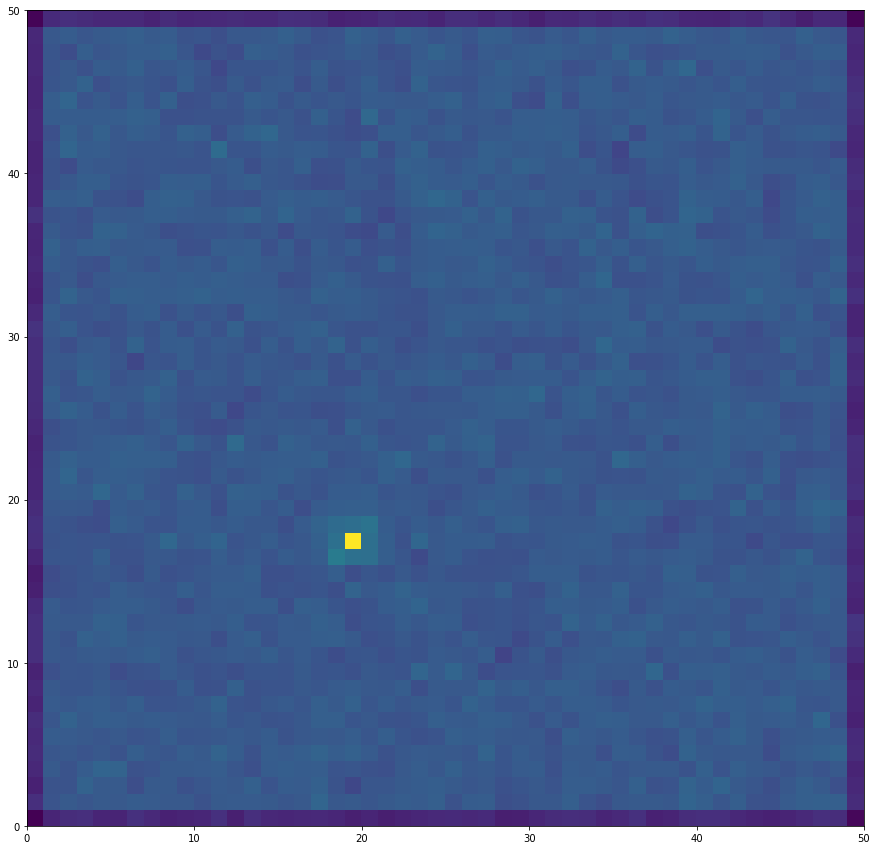

In [175]:
# Наконец, можно создать 2Д карту по матрице расстояний. К сожалению, ничего не получилось, так как видимо размер сети слишком маленький, по сравнению с размером обучающей выборки
plt.figure(figsize = (15.0, 15.0))
plt.pcolor(dist)

##### В идеале должно получиться что-то вроде этого

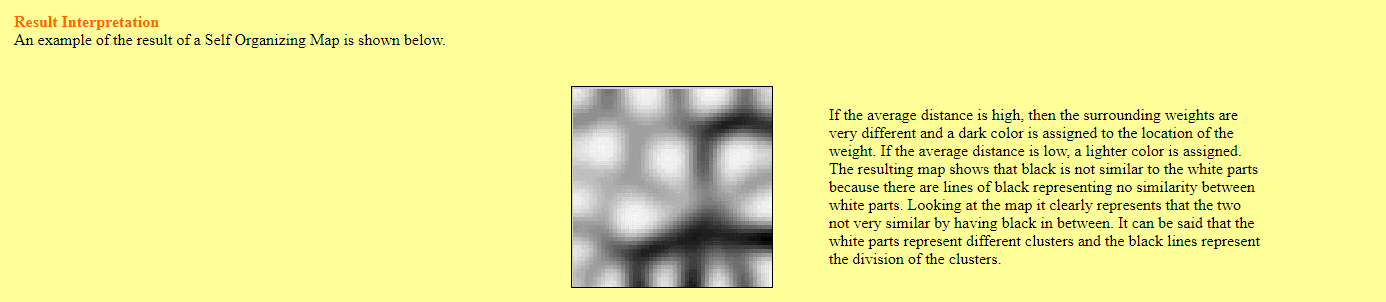

In [23]:
class_stat = data.drop(columns = ['X','Y'], inplace = True)

In [24]:
class_stat = data.groupby(by = 'Class').describe().transpose()
class_stat.to_csv(r'C:\Users\user\Documents\Palyan Production\Class_stat.csv')
class_stat.head()

Class                     0.0           1.0           2.0           3.0  \
Anisotropy count  3698.000000  13555.000000  21658.000000  25278.000000   
           mean      1.121882      1.118853      1.122553      1.124935   
           std       0.021036      0.021295      0.017747      0.015915   
           min       1.077760      1.078364      1.079382      1.082401   
           25%       1.107524      1.103034      1.109795      1.113964   

Class                      4.0           5.0           6.0  
Anisotropy count  16634.000000  18432.000000  19614.000000  
           mean       1.134698      1.131049      1.125413  
           std        0.022341      0.021352      0.013141  
           min        1.077713      1.075796      1.086245  
           25%        1.118296      1.115004      1.117216